In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

from src.utils import *

In [2]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024


# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [3]:
spy_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'spy_ohlc_df.csv')
dow_jones_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'dow_jones_ohlc_df.csv')
nasdaq_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'nasdaq_ohlc_df.csv')

In [4]:
df = nasdaq_ohlc_df[['Date', 'Close']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close
Date,
1995-01-03,398.000000
1995-01-04,399.649994
1995-01-05,398.019989
1995-01-06,401.589996
1995-01-09,403.529999


In [5]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [6]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [7]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [8]:
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model5 = create_model5(out_dim = look_ahead)
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 10)          480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________


In [9]:
model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred5 = model5.predict(xvalid)
y_pred5 = scaler.inverse_transform(y_pred5)

Epoch 1/6
313/313 [==============================] - 23s 56ms/step - loss: 9.9105e-04 - val_loss: 0.0747
Epoch 2/6
313/313 [==============================] - 14s 46ms/step - loss: 8.4850e-05 - val_loss: 0.0654
Epoch 3/6
313/313 [==============================] - 13s 41ms/step - loss: 7.5184e-05 - val_loss: 0.0571
Epoch 4/6
313/313 [==============================] - 12s 39ms/step - loss: 6.5402e-05 - val_loss: 0.0523
Epoch 5/6
313/313 [==============================] - 14s 43ms/step - loss: 6.1773e-05 - val_loss: 0.0446
Epoch 6/6
65/65 [==============================] - 2s 8ms/step


In [10]:
print('RMSE LSTM: ' + str(my_rmse(y_pred5, scaler.inverse_transform(yvalid))))

RMSE LSTM: 3234.7717


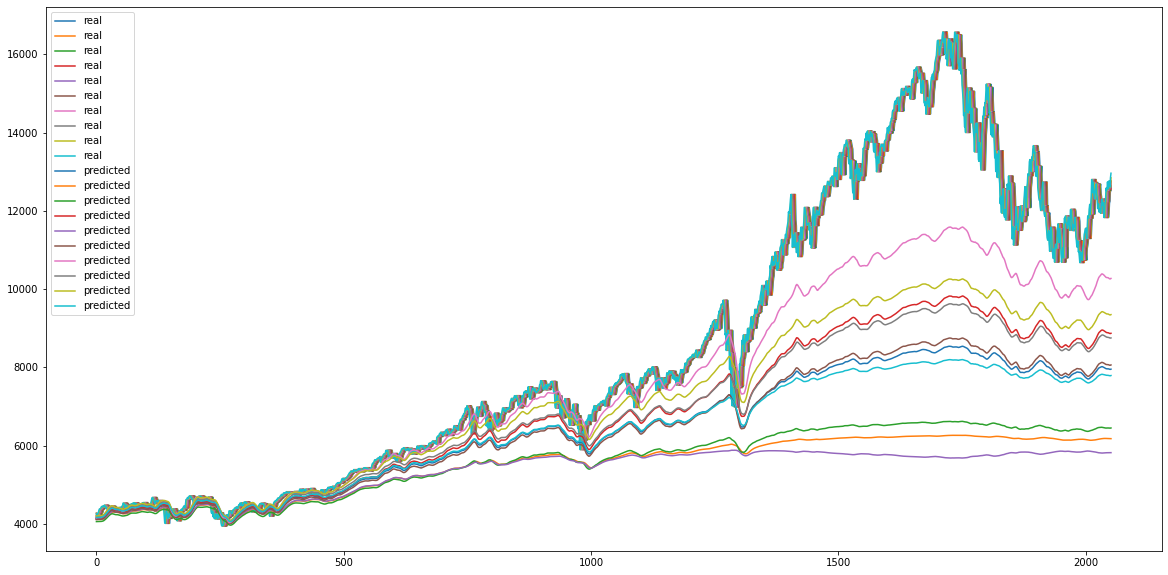

In [11]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real')
plt.plot(y_pred5, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()